# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [179]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [180]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise thinkstats2.UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise thinkstats2.UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [181]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [182]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.075

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [183]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [184]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [185]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.175

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

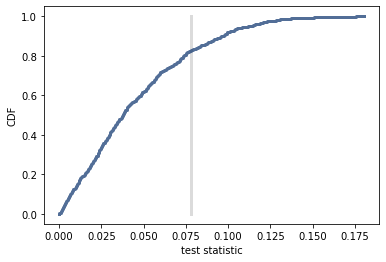

In [186]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference.

In [187]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [188]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.1

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [189]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [190]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.092

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [191]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [192]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [193]:
ht.actual, ht.MaxTestStat()

(0.0688339703541091, 0.034652421430502005)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [194]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [195]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1291

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [196]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [197]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.0407

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [198]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [199]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 26.40556858462498


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [200]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [201]:
neg_rate = FalseNegRate(data)
neg_rate

0.683

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [202]:
# 9-1
# I figured I would explain the solution to make sure I understand how it works.
# Is this what you are expecting or should I have been able to come up with this on my own?

def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    # this tells me how many records I have in my sample.
    # n is the standard variable for the amount of records in my dataset.
    n = len(live)

    # Again we are interested in separating first born babies and subsequent children.
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    # This seems to combine both into one set of data.
    data = firsts.prglngth.values, others.prglngth.values

    # This is comparing the difference in the means for firsts and others.
    # I think this one is a one tail test
    ht = DiffMeansPermute(data)

    # This calculates the pvalue based on the default 1000 iterations.
    # were running many tests to see if we can figure out where the population mean is located based on
    # the sample that we took. This uses the idea based on the central limit theorem.
    # If the distribution can be normal it will approach normal by taking many random samples.
    # The p-value is used to negate the hypothesis test.
    # We are using proof by negation here we assume that we are wrong and that the null hypothesis is in fact correct.
    # Then we find something that contradicts that assumption.
    # if the p value is small we know we can reject the null hypothesis.
    p1 = ht.PValue(iters=iters)

    # Now we are doing the same thing in regard to total birth weight.
    # We drop all records that contain NA values.
    data = (firsts.totalwgt_lb.dropna().values,
        others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # This is important just because a pvalue shows signifigant does not mean we should confirm our hypothesis.
    # We need to show that there is also a strong correlation with the data.
    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # This is another test that we can use to possibly confirm our results.
    # This is another test to get a p-value but this one is different.
    # This is more of a test that just tests the relationship between the variables.
    # It does not tell us direction or size of the relationship.
    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))
# Solution goes here

In [203]:
# so we gather the number of elements in our dataset.
n = len(live)

for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)

    # This is a divide by two and keep the integer value
    n //= 2


9148	0.17	0.00	0.00	0.00
4574	0.22	0.02	0.00	0.00
2287	0.36	0.00	0.00	0.00
1143	0.30	0.11	0.02	0.03
571	0.15	0.67	0.10	0.19
285	0.30	0.83	0.20	0.60
142	0.83	0.84	0.73	0.16


In [204]:
# Okay this was kind of brilliant. It really shows how important getting more samples is whenever possible.
# The author is taking the sample size and cutting it in half over and over again and re running the tests.

'''
n       p1      p2      p3      p4
9148	0.17	0.00	0.00	0.00
4574	0.18	0.01	0.00	0.00
2287	0.42	0.24	0.01	0.00
1143	0.62	0.62	0.62	0.00
571	    0.74	0.14	0.10	0.74
285	    0.87	0.98	0.43	0.41
142	    0.80	0.65	0.95	0.62

Exercise: In Section
'''
# p1: difference in mean pregnancy length
# The first test we fail to reject the null hypothesis in all cases. We see no real reason to think that the time is different
# between first babies or others.

# p2: difference in mean birth weight
# With a sample size of 4574 or higher we show a significant p-value now we would turn to the correlation
# to see if we can reject the null hypothesis.

# test3: correlation of mother's age and birth weight
# This one shows a sample size of 2287 or higher gives us a p-value that could lead to rejecting the null hypothesis.
# We would need to confirm that there is a correlation.

# test4: chi-square test of pregnancy length
# So the chi squared test gives good results with a sample size of 1143 or more.
# But I would be concerned about the fact that the other test in p1 failed.

# One thing that seems important here is when we re run the tests the numbers change.
# This means earring on the side of more samples whenever possible would be best.
# Solution goes here

'\nn       p1      p2      p3      p4\n9148\t0.17\t0.00\t0.00\t0.00\n4574\t0.18\t0.01\t0.00\t0.00\n2287\t0.42\t0.24\t0.01\t0.00\n1143\t0.62\t0.62\t0.62\t0.00\n571\t    0.74\t0.14\t0.10\t0.74\n285\t    0.87\t0.98\t0.43\t0.41\n142\t    0.80\t0.65\t0.95\t0.62\n\nExercise: In Section\n'

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [205]:
# So by passing DiffMeansPermute into DiffMeansResample we get the inheritance we were looking for.
class DiffMeansResample(DiffMeansPermute):
    """Tests a difference in means using resampling."""

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        # The author stated that one way to prove causation is to take random samples
        # This also goes toward the idea of finding the population mean by randomly choosing
        # samples from our dataset. This is in line with the Central Limit Theorem.
        '''
        According to https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Probability/BS704_Probability12.html#:~:text=of%20Z%20Scores-,Central%20Limit%20Theorem,will%20be%20approximately%20normally%20distributed.

        The central limit theorem states that if you have a population with mean μ
        and standard deviation σ and take sufficiently large random samples from the
        population with replacement, then the distribution of the sample means will
        be approximately normally distributed. This will hold true regardless of whether
        the source population is normal or skewed, provided the sample size is sufficiently
        large (usually n > 30). If the population is normal, then the theorem holds true
        even for samples smaller than 30. In fact, this also holds true even if the
        population is binomial, provided that min(np, n(1-p))> 5, where n is the sample
        size and p is the probability of success in the population. This means that we
        can use the normal probability model to quantify uncertainty when making inferences
        about a population mean based on the sample mean.
        '''
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2
# Solution goes here

In [206]:
# This looks for differences in means if we keep resampling we should zero in
# on the population mean even though we don't have actual data on what the population
# mean is. This is one of the major ideas in statistics the central limit theorem.

def RunResampleTest(firsts, others):
    """Tests differences in means by resampling.

    firsts: DataFrame
    others: DataFrame
    """
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample preglength')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample birthweight')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())
# Solution goes here

In [207]:
RunResampleTest(firsts, others)
# Solution goes here


diff means resample preglength
p-value = 0.1654
actual = 0.07803726677754952
ts max = 0.24681172622597813

diff means resample birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.11686887548551805


In [115]:
# Again we fail to reject the null hypothesis for preglength
# The p-value is still just too high.

# When looking at birth weight we would have grounds to reject the null hypothesis.
# The pvalue is compelling this time.

# Solution goes here